# Modelagem de churn

Este notebook prepara features, treina modelos e compara métricas.

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline

sys.path.append("..")

from src.ml_pipeline import load_dataset, split_features_target, build_preprocessor, build_models, train_test_split_stratified

sns.set_theme(style="whitegrid")

In [2]:
import sklearn

diagnostic_start = time.perf_counter()
pd.__version__, np.__version__, sklearn.__version__

('2.3.3', '2.4.0', '1.8.0')

In [3]:
data_path = "../data/processed/churn_final.csv"
load_start = time.perf_counter()
df = load_dataset(data_path)
load_seconds = time.perf_counter() - load_start

target_col = "churn_binary"
drop_cols = ["customerID", "Churn", target_col]

x, y = split_features_target(df, target_col, drop_cols)

categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = x.select_dtypes(include=[np.number]).columns.tolist()

df.shape, load_seconds

((7267, 25), 0.024220300023443997)

In [4]:
preprocessor = build_preprocessor(categorical_cols, numeric_cols)
splits = train_test_split_stratified(x, y, test_size=0.2, random_state=42)

In [5]:
preprocess_start = time.perf_counter()
preprocessor.fit(splits.x_train)
preprocess_seconds = time.perf_counter() - preprocess_start
preprocess_seconds

0.0233128999825567

In [6]:
cardinality = x[categorical_cols].nunique().sort_values(ascending=False)
total_onehot_features = int(cardinality.sum())
cardinality.head(10), total_onehot_features

(account.PaymentMethod        4
 internet.InternetService     3
 internet.OnlineSecurity      3
 internet.DeviceProtection    3
 internet.TechSupport         3
 internet.OnlineBackup        3
 phone.MultipleLines          3
 internet.StreamingTV         3
 internet.StreamingMovies     3
 account.Contract             3
 dtype: int64,
 41)

In [7]:
base_models = build_models(random_state=42)
pipelines = {
    name: Pipeline(
        [
            ("preprocess", preprocessor),
            ("model", model.named_steps["model"]),
        ]
    )
    for name, model in base_models.items()
}

results = []

In [8]:
for name, pipeline in pipelines.items():
    start = time.perf_counter()
    pipeline.fit(splits.x_train, splits.y_train)
    fit_seconds = time.perf_counter() - start
    y_pred = pipeline.predict(splits.x_test)
    y_prob = None
    if hasattr(pipeline, "predict_proba"):
        y_prob = pipeline.predict_proba(splits.x_test)[:, 1]

    metrics = {
        "model": name,
        "accuracy": accuracy_score(splits.y_test, y_pred),
        "precision": precision_score(splits.y_test, y_pred),
        "recall": recall_score(splits.y_test, y_pred),
        "f1": f1_score(splits.y_test, y_pred),
        "roc_auc": roc_auc_score(splits.y_test, y_prob) if y_prob is not None else np.nan,
        "fit_seconds": fit_seconds,
    }
    results.append(metrics)

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_df

,model,accuracy,precision,recall,f1,roc_auc,fit_seconds
0,LogisticRegression,0.744154,0.501656,0.810160,0.619632,0.843532,0.059400
2,GradientBoosting,0.807428,0.659864,0.518717,0.580838,0.847459,1.297066
1,RandomForest,0.777854,0.583607,0.475936,0.524300,0.820935,0.642405


In [9]:
best_model_name = results_df.iloc[0]["model"]
best_pipeline = pipelines[best_model_name]

best_pred = best_pipeline.predict(splits.x_test)
best_prob = best_pipeline.predict_proba(splits.x_test)[:, 1]

best_model_name

'LogisticRegression'

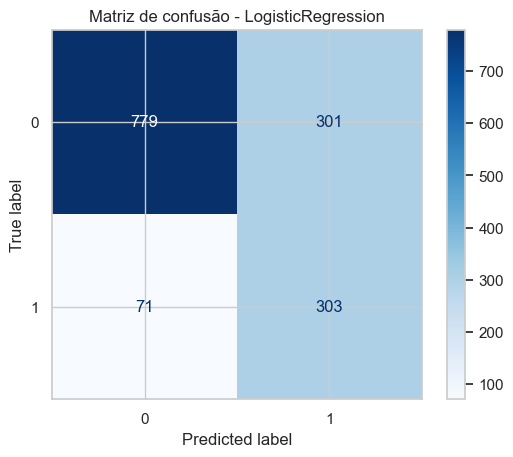

In [10]:
cm = confusion_matrix(splits.y_test, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Matriz de confusão - {best_model_name}")
plt.show()

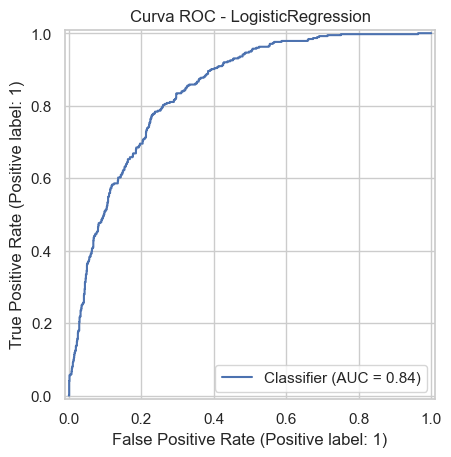

In [11]:
RocCurveDisplay.from_predictions(splits.y_test, best_prob)
plt.title(f"Curva ROC - {best_model_name}")
plt.show()